# Electronic bandstructure of Aluminum

## Introduction
In solid-state physics an electronic bandstructure describes the ranges of energy that electrons are forbidden from or allowed to have. The electronic bandstructure of a material determines several characteristics, in particular its electronic and optical properties. There are several quantum mechanical theories such as `density functional theory`, `tight-binding approximation` and `dynamical mean field theory` that can be used to predict electronic bandstructure given crytsal structure information (such as atomic coordinates, elemental types and crystal-lattice vectors). 

Electronic bandstructure calculations can also be viewed as predicting eigenvalues of electronic Hamiltonian matrix at different crystal momentum (also known as K-points in the Brillouin zone). In this tutorial, we will learn how to use `Wannier Tight-binding Hamiltonian (WTBH)`, `Variational Quantum Eigen solver (VQE)` and `Variational Quantum Deflation (VQD)` algorithms to predict electronic bandstructure of face-centered cubic (FCC) Aluminum metal. 

Wannier functions are a complete orthonormalized basis set that acts as a bridge between a delocalized plane wave representation commonly used in electronic structure calculations and a localized atomic orbital basis that more naturally describes chemical bonds. WTBHs are a computationally efficient way to calculate properties of materials. One of the most common ways of obtaining WTBHs is by using density functional theory calculations. We developed a database of WTBHs for thousands of materials in our previous work, out of which we will use the WTBH of Aluminum as an example.

More details about this work can be found in the reference: [Quantum computation for predicting electron and phonon properties of solids](https://iopscience.iop.org/article/10.1088/1361-648X/ac1154/meta)

## Obtain a tight-binding Hamiltonian
We will use the [JARVIS-Tools](https://github.com/usnistgov/jarvis/blob/master/jarvis/io/qiskit/inputs.py) software package to obtain the WTBH for FCC Aluminum (JARVIS-ID: [JVASP-816](https://www.ctcms.nist.gov/~knc6/static/JARVIS-DFT/JVASP-816.xml)). Install using `pip install jarvis-tools` or `conda install -c conda-forge jarvis-tools`.

The function `get_wann_electron` returns the Wannier Tight-binding Hamiltonian (`wtbh`), Fermi-energy (`ef`) and atomic structure information (`atoms`). For options other than Aluminum, find the link [here](https://github.com/usnistgov/atomqc/blob/master/atomqc/data/electron_vqe_np_jid.csv).

In [1]:
from jarvis.db.figshare import get_wann_electron, get_hk_tb
from jarvis.core.circuits import QuantumCircuitLibrary
from jarvis.io.qiskit.inputs import (
    get_bandstruct,
    HermitianSolver,
    decompose_Hamiltonian,
)

wtbh, ef, atoms = get_wann_electron("JVASP-816")


Obtaining raw io files 145k...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Loading the zipfile...
Loading completed.
H size 15 13 15 8 8


In [2]:
print (wtbh)

In [3]:
print (ef)

7.92891188


In [4]:
print (atoms)

Al
1.0
2.49077 -0.0 1.438047
0.830257 2.348321 1.438047
-0.0 -0.0 2.876094
Al
1
Cartesian
0.0 0.0 0.0



Now, we can obtain WTBH at a particular crystal momentum `k-point ([0.0,0.0.,0.0], also known as $\Gamma$ point)`.

In [5]:
hk = get_hk_tb(w=wtbh, k=[0.0, 0.0, 0.0])

In [6]:
print (hk.shape)

(8, 8)


## Decompose Hermitian matrix

The size of the Hermitian matrix is 8x8 is due to the number of orbitals involved in the WTBH: s, px, py, pz with spin up/down for each of them. Before using VQE, we can decompose the Hermitian matrix into Pauli matrices.

$A = \sum \limits _{i,j,k,l} ^{} h_{ijkl}{\sigma}_{i}\otimes{\sigma}_{j}\otimes{\sigma}_{k}\otimes{\sigma}_{l} $

In [7]:
Hamil_op = decompose_Hamiltonian(hk)
print ('N qubits:', Hamil_op.num_qubits)
print ('N Operators:', len(Hamil_op.to_pauli_op()))
print ('Operators coeff:', Hamil_op.to_pauli_op())

N qubits: 3
N Operators: 64
Operators coeff: SummedOp([
  15.474351124999991 * III,
  -0.028395749999999543 * IIX,
  -0.015957999999999993 * IIY,
  -6.230836624999982 * IIZ,
  0.012033500000001297 * IXI,
  0.014423249999999839 * IXX,
  -4.475000000000006e-05 * IXY,
  0.011959500000001358 * IXZ,
  -4.224999999999999e-05 * IYI,
  2.4249999999999912e-05 * IYX,
  -0.01443724999999988 * IYY,
  7.175000000000012e-05 * IYZ,
  -6.214984875000006 * IZI,
  -0.02821675000000051 * IZX,
  0.015957999999999993 * IZY,
  -6.230797125000001 * IZZ,
  4.374999999999993e-05 * XII,
  1.7499999999999934e-05 * XIX,
  -9.624999999999997e-05 * XIY,
  7.525000000000024e-05 * XIZ,
  -9.69999999999996e-05 * XXI,
  0.00032974999999999796 * XXX,
  -0.00013300000000000033 * XXY,
  6.649999999999954e-05 * XXZ,
  -0.00686825 * XYI,
  0.00017100000000000033 * XYX,
  0.00032974999999999807 * XYY,
  0.006863750000000001 * XYZ,
  -0.0001362500000000001 * XZI,
  -3.5499999999999996e-05 * XZX,
  0.00011274999999999996 * XZY

i.e. $2^n \times 2^n$, n = number of qubits

In [8]:
len(Hamil_op.to_pauli_op()) 

64

## Run VQE

Now, we will use `HermitianSolver`, which uses Qiskit's circuit, and VQE libraries to predict the lowest energy level of this matrix. Note this module automatically decomposes the Hermitian matrix, sets up ansatz/circuit, optimizers etc.

In [9]:
H = HermitianSolver(hk)
qc = QuantumCircuitLibrary(n_qubits=3).circuit6() # 2^3  = 8
en, vqe_result, vqe = H.run_vqe(mode="min_val", var_form=qc)


In [10]:
print (en)

(-3.240664069330004+0j)


In [11]:
print (vqe_result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 210,
    'eigenstate': array([ 7.61436980e-01-6.48238186e-01j, -1.57487306e-06-2.73016468e-06j,
        6.53211756e-05-5.56132582e-05j, -1.35112578e-10-2.34213525e-10j,
        5.71621718e-04+8.03932527e-04j,  2.81817028e-09-1.31313233e-09j,
        4.90405308e-08+6.89669895e-08j,  2.41764014e-13-1.12658395e-13j]),
    'eigenvalue': (-3.240664069330004+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[3]): 2.8399008218171593,
                              ParameterVectorElement(θ[4]): -3.1415433593028936,
                              ParameterVectorElement(θ[5]): -0.0016882010851949842,
                              ParameterVectorElement(θ[6]): -3.141586349929251,
                              ParameterVectorElement(θ[7]): -0.00017157736039777563,
                              ParameterVectorElement(θ[8]): -1.0551410262233818,
                              ParameterVectorElement(θ[9]): -1.38874488585667,
     

In [12]:
print (qc)

     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
«     ┌──────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                             ├
«     │                                                                              │
«q_1: ┤1 EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11]) ├
«     │                                                                              │
«q_2: ┤2                                                                             ├
«     └──────────────────────────────────────────────────────────────────────────────┘


## Run VQE on multiple k-points to obtain bandstructure

In the above example, we solved the WTBH for $\Gamma$ k-point [0.0,0.0.,0.0] only. Solving the same problem for other high-symmetry k-points in the Brillouin zone leads to electronic bandstructure. We will solve this first for a less dense grid of k-points and then for a denser k-point grids. Note that the denser k-point grid might run for more than 15 minutes.

/home/kamalch/miniconda3/envs/qiskit/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


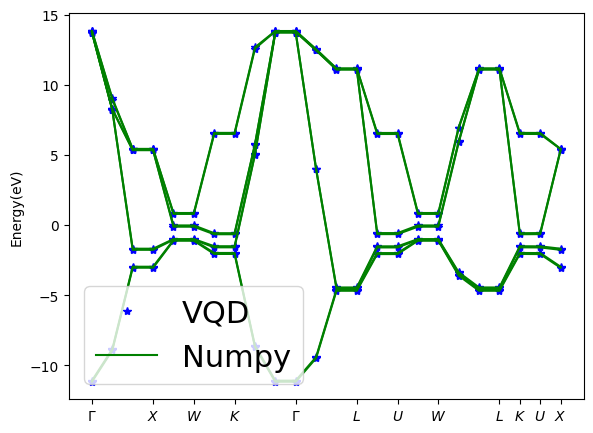

CPU times: user 7min 11s, sys: 14.7 s, total: 7min 26s
Wall time: 7min 11s


In [13]:
%%time
import matplotlib.pyplot as plt

%matplotlib inline
line_density = 1
info_1 = get_bandstruct(
    w=wtbh,
    atoms=atoms,
    ef=ef,
    line_density=line_density,
    savefig=False,
    verbose=False,
    ylabel="Energy(eV)",
)


/home/kamalch/miniconda3/envs/qiskit/lib/python3.8/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


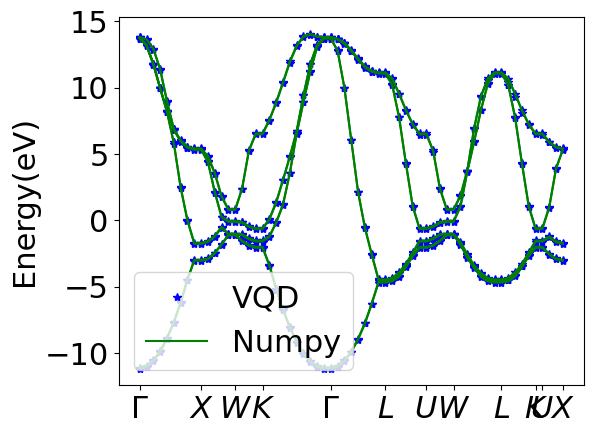

CPU times: user 17min 36s, sys: 32.9 s, total: 18min 9s
Wall time: 17min 35s


In [14]:
%%time
line_density = 5
info_5 = get_bandstruct(
    w=wtbh,
    atoms=atoms,
    ef=ef,
    line_density=line_density,
    savefig=False,
    verbose=False,
    ylabel="Energy(eV)",
)


These examples use statevector_simulator, but actual quantum computers can also be used by changing backend in the HermitialSolver class.

In [15]:
import jarvis
jarvis.__version__

'2022.09.16'

In [16]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright